In [1]:
import os
import sys
import logging
import warnings

project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_path not in sys.path:
    sys.path.append(project_path)

warnings.filterwarnings("always")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

In [2]:
import pandas as pd
import mplfinance as mpf
import yfinance as yf
from transformers import pipeline
from tradingview_ta import TA_Handler
from ta.trend import SMAIndicator, EMAIndicator, MACD, PSARIndicator
from ta.momentum import RSIIndicator, TSIIndicator

from binance import (
    get_latest_price,
    get_klines_for_year,
    klines_to_df,
    klines_df_check,
    update_klines,
)

In [3]:
get_latest_price("BTCUSDT")

{'symbol': 'BTCUSDT', 'price': '82439.18000000'}

In [4]:
ticker = yf.Ticker("BTC")
news = ticker.news
len(news)

10

In [5]:
pipe = pipeline("text-classification", model="ProsusAI/finbert")

Device set to use cpu


In [6]:
for article in news:
    print(article["content"]["title"])
    print(pipe(article["content"]["title"]))
    print(article["content"]["pubDate"])
    print(article["content"]["contentType"])
    print(article["content"]["summary"])
    print(pipe(article["content"]["summary"]))
    print()

SEC Drops Ripple Case as XRP ETF Approval Odds Rise
[{'label': 'negative', 'score': 0.5940104126930237}]
2025-03-20T21:45:00Z
STORY
With regulatory clarity emerging and multiple ETF applications already filed, prediction markets now show 82% odds of XRP fund approval in 2025.
[{'label': 'positive', 'score': 0.8557353615760803}]

Tap Into the Burgeoning Bitcoin Economy with Fold Holdings – Initiation Report
[{'label': 'neutral', 'score': 0.7109472155570984}]
2025-03-04T15:37:29Z
STORY
By Rayk Riechmann From banks to hedge funds to mom-and-pop investors, the Bitcoin (BTC) boom has garnered support from virtually every direction, with President Donald Trump this week vowing to create a strategic crypto reserve for the U.S. government. What if investors could bet on growth across the new Bitcoin economy while also getting direct […]
[{'label': 'neutral', 'score': 0.8073106408119202}]

As European equities outperform US equities, is Nvidia the fix?
[{'label': 'neutral', 'score': 0.809350430

In [7]:
btc_ta_handler = TA_Handler(
    symbol="BTCUSDT",
    screener="crypto",
    exchange="binance",
    interval="1h"
)

btc_ta_analysis = btc_ta_handler.get_analysis()

if btc_ta_analysis:
    print(btc_ta_analysis.summary)

{'RECOMMENDATION': 'SELL', 'BUY': 5, 'SELL': 14, 'NEUTRAL': 7}


In [8]:
symbol = "BTCUSDT"
year = 2025
interval = "1h"
csv_file = f"../cache/klines/{symbol}-{year}-{interval}.csv"

if not os.path.exists(csv_file):
    print(f"Downloading {symbol} {year} {interval} data...")
    btc_data = klines_to_df(get_klines_for_year(symbol, year, interval))
    btc_data.to_csv(csv_file, index_label="Open Time")

else:
    btc_data = update_klines(csv_file, symbol, interval)

klines_df_check(btc_data)

2025-03-29 13:59:07,581 INFO Updating BTCUSDT 1h data...
2025-03-29 13:59:07,583 INFO Downloading BTCUSDT 1h data from 2025-03-07 23:00:00 to 2025-03-28 19:00:00...
2025-03-29 13:59:08,885 INFO Downloading BTCUSDT 1h data from 2025-03-28 19:00:00 to 2025-03-29 12:59:07...


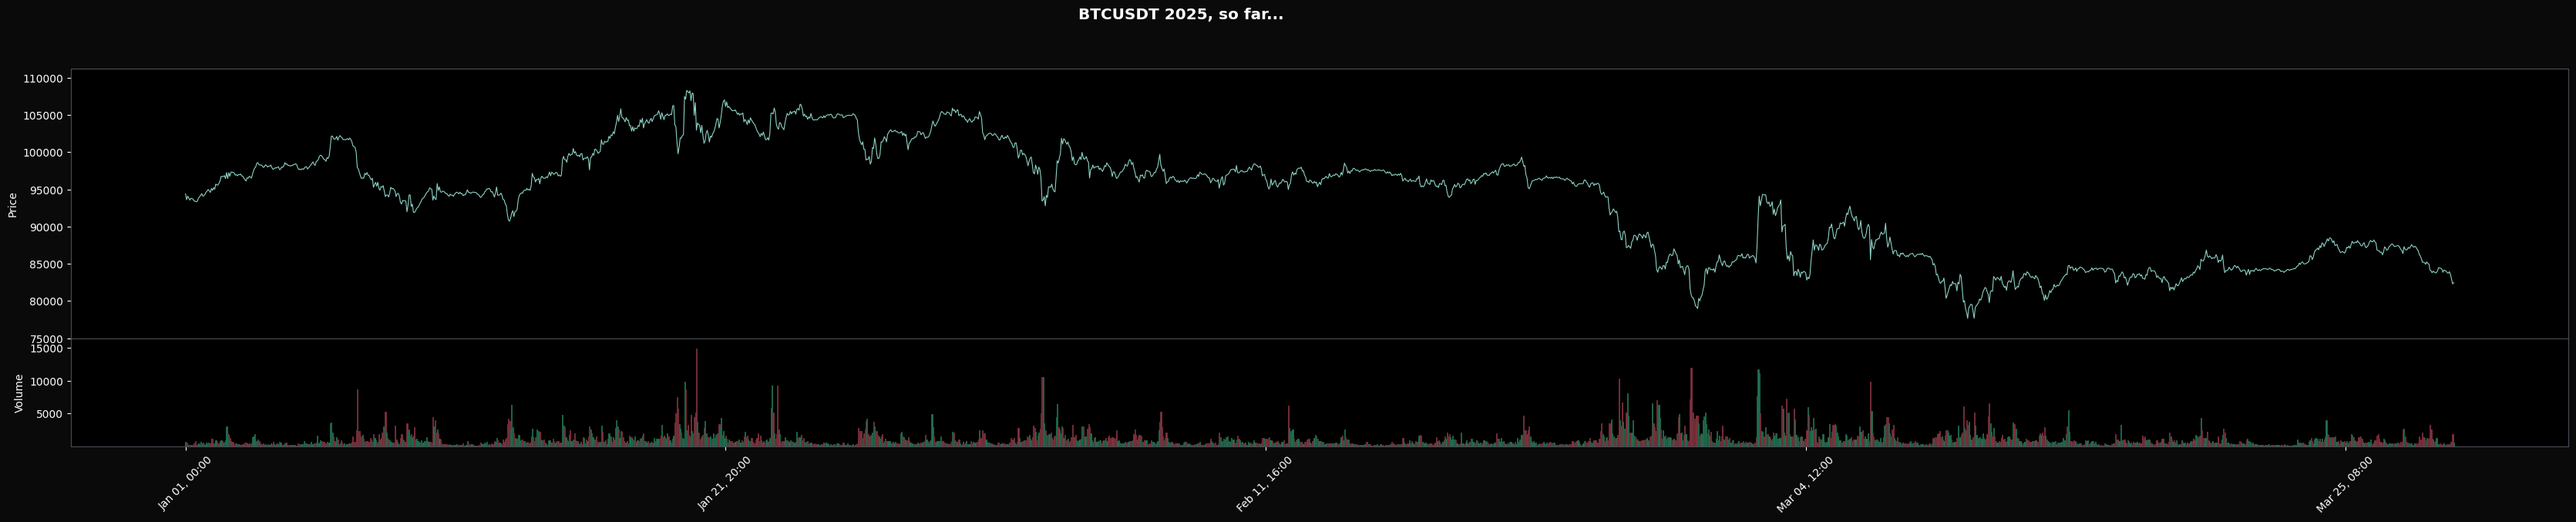

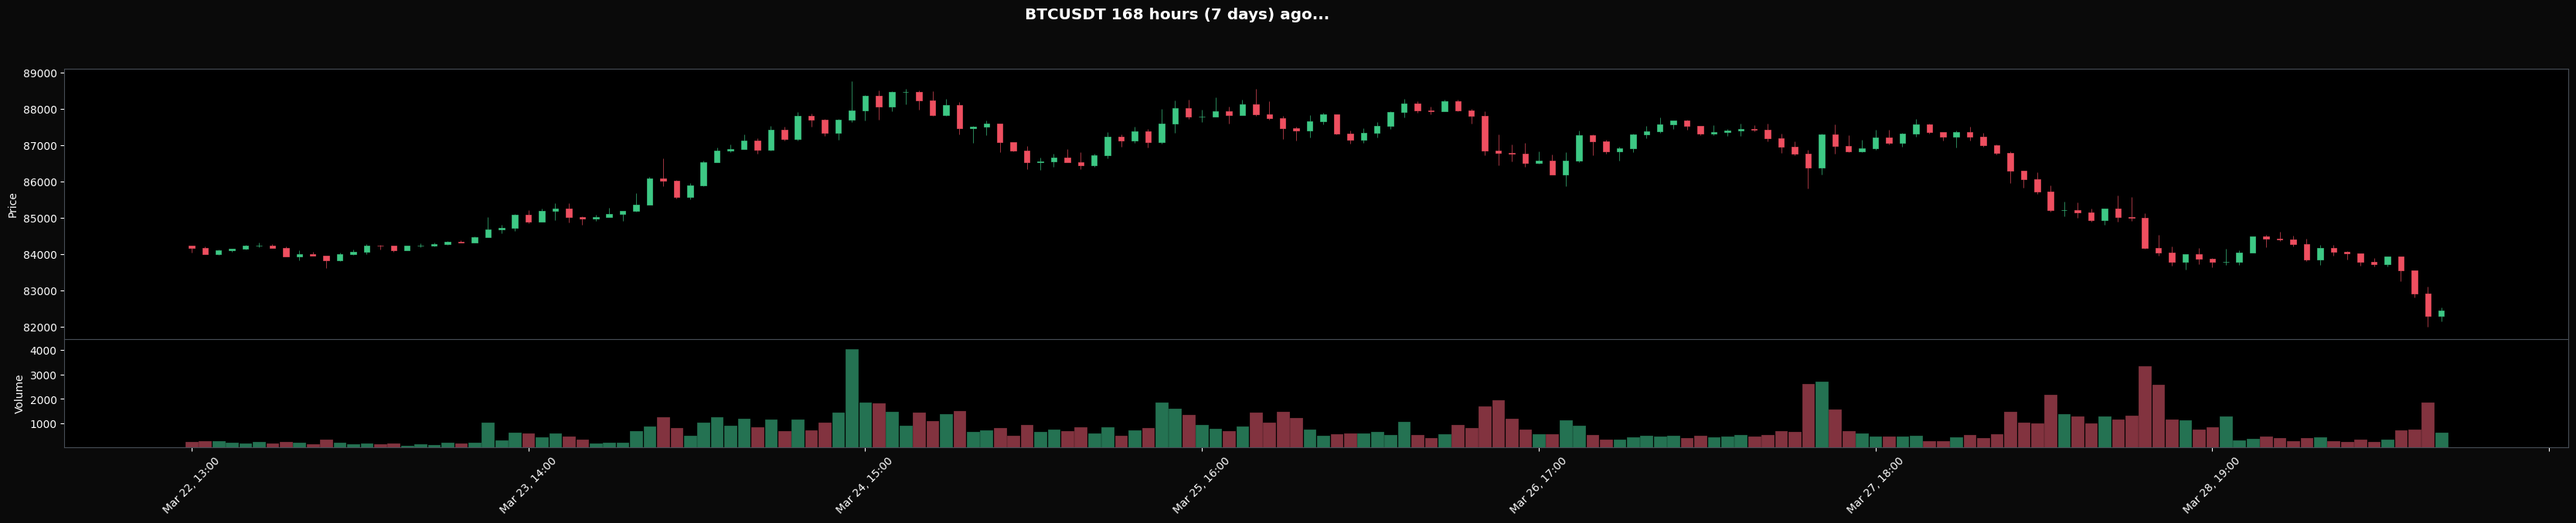

In [9]:
NUM_OF_CANDLES = 24 * 7
STYLE = mpf.make_mpf_style(base_mpf_style="binancedark", gridstyle="", y_on_right=False)
FIGSIZE = (45, 7)


def _create_histogram(series: pd.Series, panel: int) -> list:
    colors = []
    for i in range(0, len(series)):
        if series.iloc[i] >= 0 and series.iloc[i - 1] < series.iloc[i]:
            colors.append("#3dc985")
        elif series.iloc[i] >= 0 and series.iloc[i - 1] > series.iloc[i]:
            colors.append("#ef4f60")
        elif series.iloc[i] < 0 and series.iloc[i - 1] > series.iloc[i]:
            colors.append("#ef4f60")
        elif series.iloc[i] < 0 and series.iloc[i - 1] < series.iloc[i]:
            colors.append("#3dc985")
        else:
            colors.append("#000000")
    return [
        mpf.make_addplot([0] * len(series), color="w", alpha=0.25, secondary_y=False, panel=panel),
        mpf.make_addplot(series, color="w", alpha=0.25, panel=panel),
        mpf.make_addplot(series, type="bar", width=0.8, color=colors, panel=panel)
    ]


mpf.plot(btc_data, type="line", title=f"BTCUSDT {year}, so far...", volume=True, style=STYLE, figsize=FIGSIZE)
mpf.plot(btc_data.tail(NUM_OF_CANDLES), type="candle", title=f"BTCUSDT {NUM_OF_CANDLES} hours ({NUM_OF_CANDLES // 24} days) ago...", volume=True, style=STYLE, figsize=FIGSIZE)

In [10]:
indicators = {}

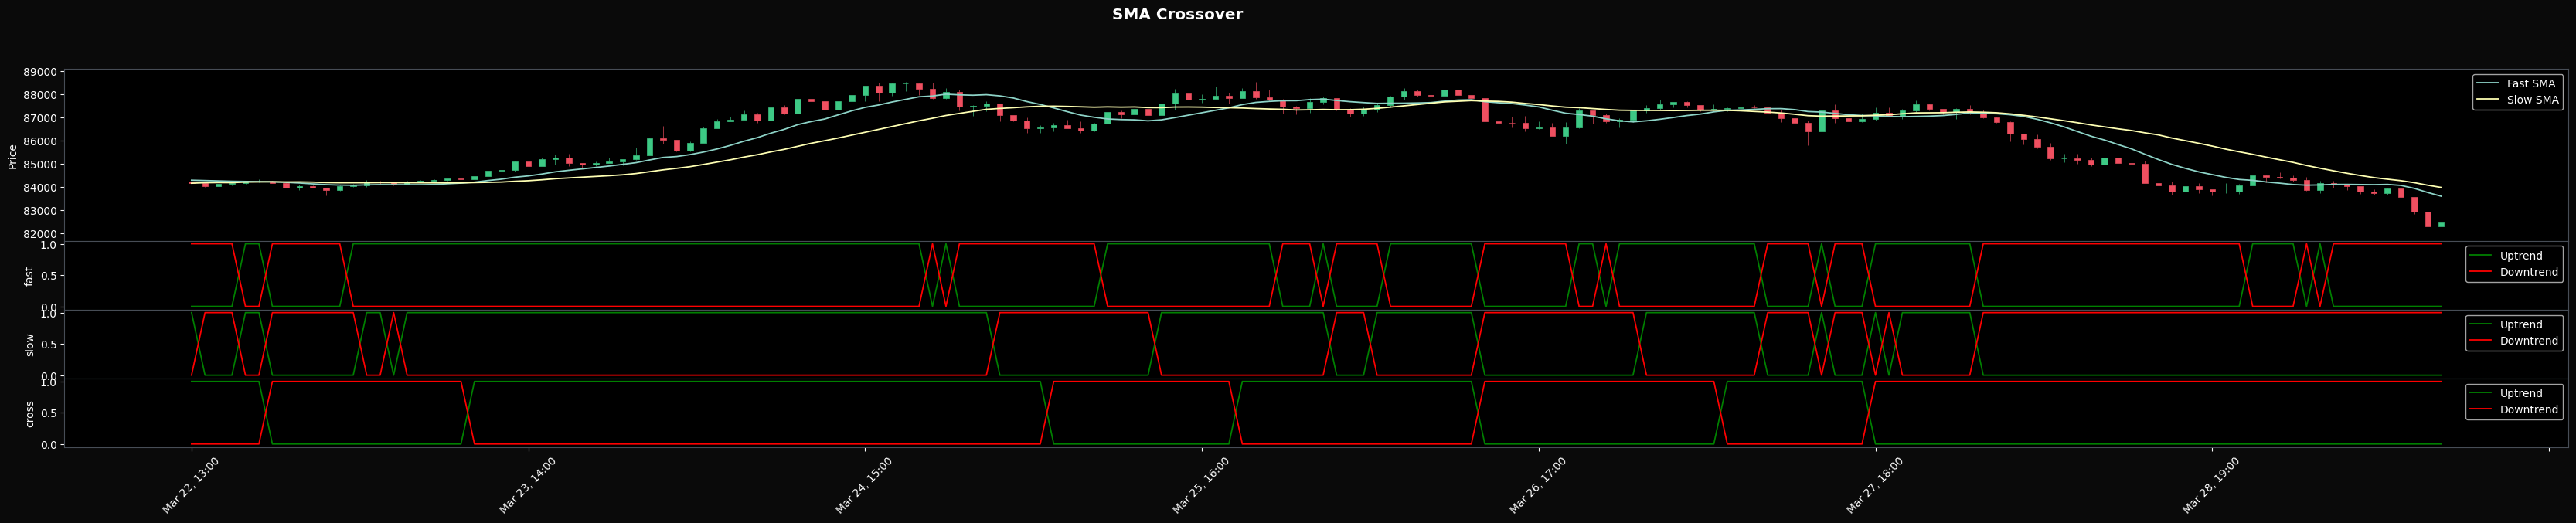

fast sma  -> False
slow sma  -> False
crossover -> False


In [11]:
fast_sma = SMAIndicator(btc_data["Close"], window=12).sma_indicator()
slow_sma = SMAIndicator(btc_data["Close"], window=26).sma_indicator()

mpf.plot(btc_data.tail(NUM_OF_CANDLES), type="candle", title="SMA Crossover", style=STYLE, figsize=FIGSIZE, addplot=[
    mpf.make_addplot(fast_sma.tail(NUM_OF_CANDLES), label="Fast SMA"),
    mpf.make_addplot(slow_sma.tail(NUM_OF_CANDLES), label="Slow SMA"),
    # fast sma signal
    mpf.make_addplot(btc_data.tail(NUM_OF_CANDLES)["Close"] > fast_sma.tail(NUM_OF_CANDLES), color="g", panel=1, ylabel="fast", label="Uptrend"),
    mpf.make_addplot(btc_data.tail(NUM_OF_CANDLES)["Close"] < fast_sma.tail(NUM_OF_CANDLES), color="r", panel=1, ylabel="fast", label="Downtrend"),
    # slow sma signal
    mpf.make_addplot(btc_data.tail(NUM_OF_CANDLES)["Close"] > slow_sma.tail(NUM_OF_CANDLES), color="g", panel=2, ylabel="slow", label="Uptrend"),
    mpf.make_addplot(btc_data.tail(NUM_OF_CANDLES)["Close"] < slow_sma.tail(NUM_OF_CANDLES), color="r", panel=2, ylabel="slow", label="Downtrend"),
    # crossover signal
    mpf.make_addplot(fast_sma.tail(NUM_OF_CANDLES) > slow_sma.tail(NUM_OF_CANDLES), color="g", panel=3, ylabel="cross", label="Uptrend"),
    mpf.make_addplot(fast_sma.tail(NUM_OF_CANDLES) < slow_sma.tail(NUM_OF_CANDLES), color="r", panel=3, ylabel="cross", label="Downtrend")
])

print("fast sma  ->", btc_data.iloc[-1]["Close"] > fast_sma.iloc[-1])
print("slow sma  ->", btc_data.iloc[-1]["Close"] > slow_sma.iloc[-1])
print("crossover ->", fast_sma.iloc[-1] > slow_sma.iloc[-1])

indicators["fast_sma"] = bool(btc_data.iloc[-1]["Close"] > fast_sma.iloc[-1])
indicators["slow_sma"] = bool(btc_data.iloc[-1]["Close"] > slow_sma.iloc[-1])
indicators["sma_crossover"] = bool(fast_sma.iloc[-1] > slow_sma.iloc[-1])

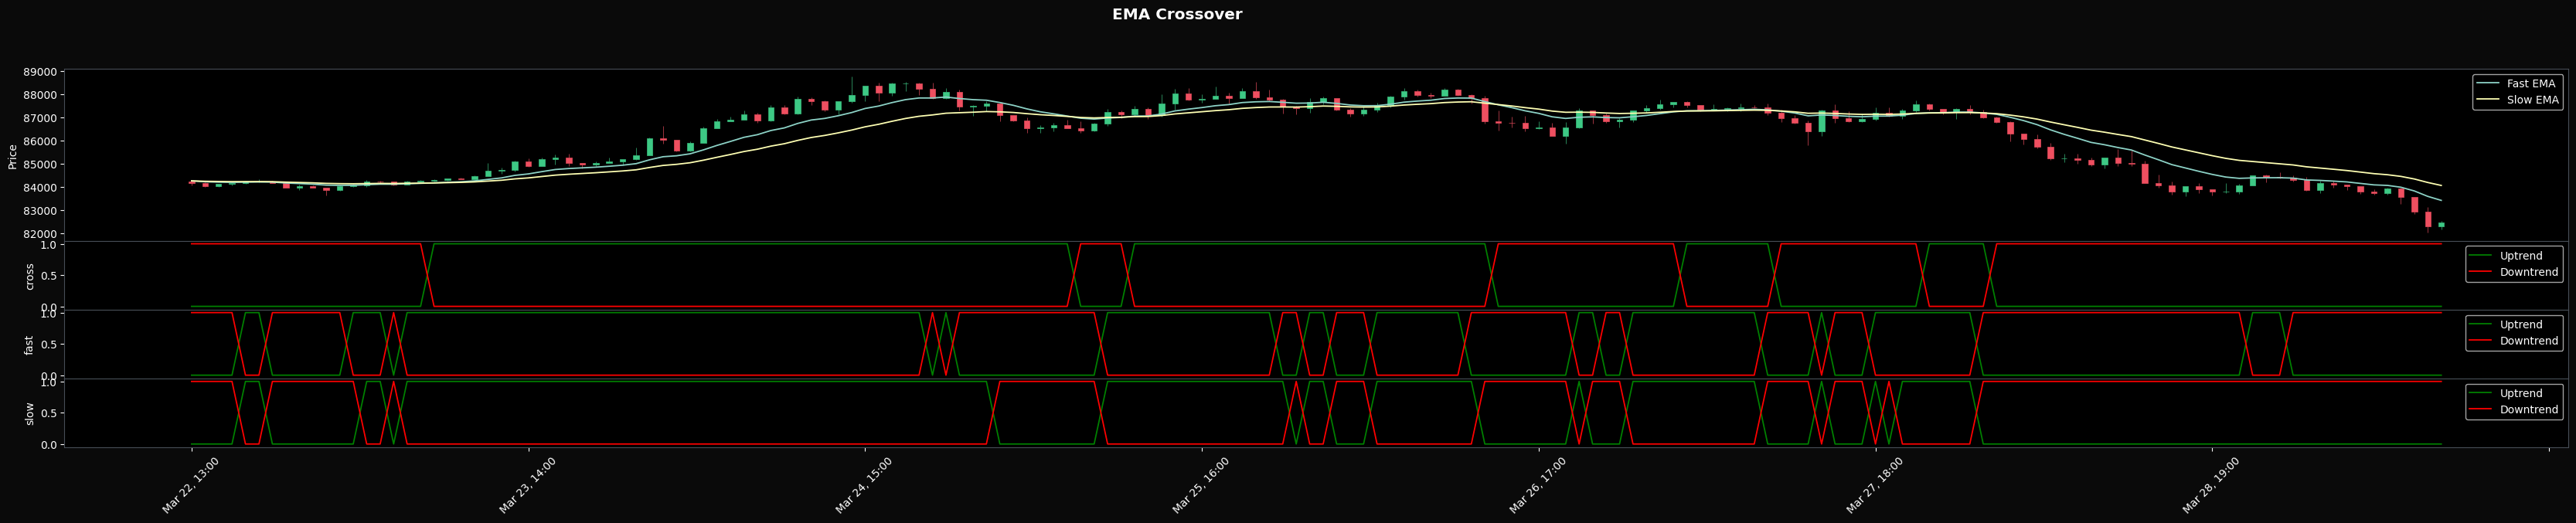

fast ema  -> False
slow ema  -> False
crossover -> False


In [12]:
fast_ema = EMAIndicator(btc_data["Close"], window=12).ema_indicator()
slow_ema = EMAIndicator(btc_data["Close"], window=26).ema_indicator()

mpf.plot(btc_data.tail(NUM_OF_CANDLES), type="candle", title="EMA Crossover", style=STYLE, figsize=FIGSIZE, addplot=[
    mpf.make_addplot(fast_ema.tail(NUM_OF_CANDLES), label="Fast EMA"),
    mpf.make_addplot(slow_ema.tail(NUM_OF_CANDLES), label="Slow EMA"),
    # fast ema signal
    mpf.make_addplot(btc_data.tail(NUM_OF_CANDLES)["Close"] > fast_ema.tail(NUM_OF_CANDLES), color="g", panel=2, ylabel="fast", label="Uptrend"),
    mpf.make_addplot(btc_data.tail(NUM_OF_CANDLES)["Close"] < fast_ema.tail(NUM_OF_CANDLES), color="r", panel=2, ylabel="fast", label="Downtrend"),
    # slow ema signal
    mpf.make_addplot(btc_data.tail(NUM_OF_CANDLES)["Close"] > slow_ema.tail(NUM_OF_CANDLES), color="g", panel=3, ylabel="slow", label="Uptrend"),
    mpf.make_addplot(btc_data.tail(NUM_OF_CANDLES)["Close"] < slow_ema.tail(NUM_OF_CANDLES), color="r", panel=3, ylabel="slow", label="Downtrend"),
    # crossover signal
    mpf.make_addplot(fast_ema.tail(NUM_OF_CANDLES) > slow_ema.tail(NUM_OF_CANDLES), color="g", panel=1, ylabel="cross", label="Uptrend"),
    mpf.make_addplot(fast_ema.tail(NUM_OF_CANDLES) < slow_ema.tail(NUM_OF_CANDLES), color="r", panel=1, ylabel="cross", label="Downtrend")
])

print("fast ema  ->", btc_data.iloc[-1]["Close"] > fast_ema.iloc[-1])
print("slow ema  ->", btc_data.iloc[-1]["Close"] > slow_ema.iloc[-1])
print("crossover ->", fast_ema.iloc[-1] > slow_ema.iloc[-1])

indicators["fast_ema"] = bool(btc_data.iloc[-1]["Close"] > fast_ema.iloc[-1])
indicators["slow_ema"] = bool(btc_data.iloc[-1]["Close"] > slow_ema.iloc[-1])
indicators["ema_crossover"] = bool(fast_ema.iloc[-1] > slow_ema.iloc[-1])

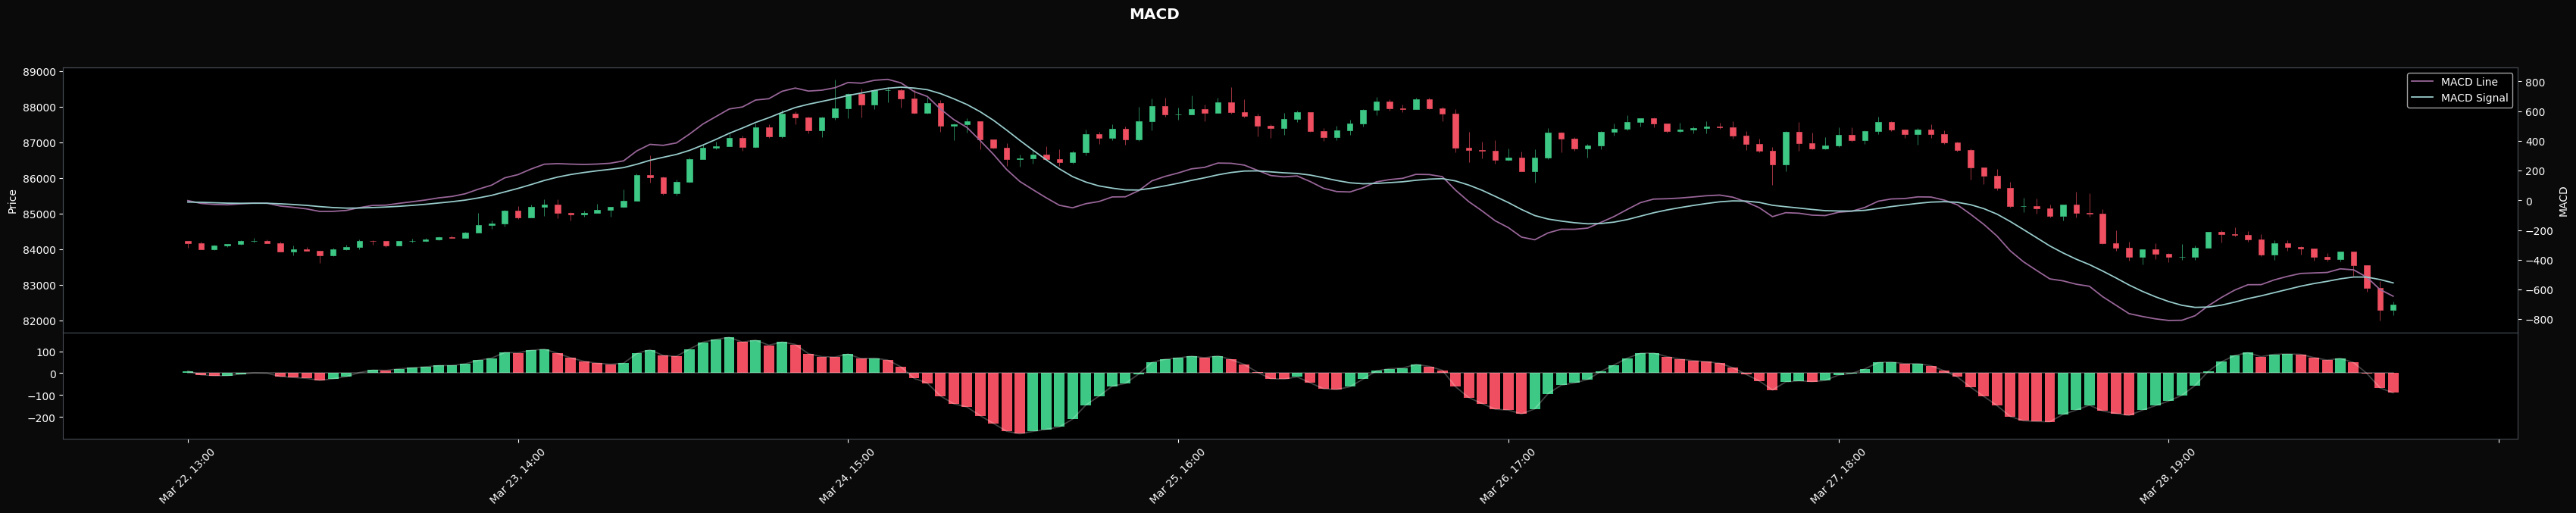

macd  -> False


In [13]:
macd = MACD(btc_data["Close"], window_slow=26, window_fast=12, window_sign=9)

mpf.plot(btc_data.tail(NUM_OF_CANDLES), type="candle", title="MACD", style=STYLE, figsize=FIGSIZE, addplot=[
    mpf.make_addplot(macd.macd().tail(NUM_OF_CANDLES), ylabel="MACD", label="MACD Line", color="#996699"),
    mpf.make_addplot(macd.macd_signal().tail(NUM_OF_CANDLES), label="MACD Signal", color="#99cccc"),
    *_create_histogram(macd.macd_diff().tail(NUM_OF_CANDLES), panel=1)
])

print("macd  ->", macd.macd().iloc[-1] > macd.macd_signal().iloc[-1])

indicators["macd"] = bool(macd.macd().iloc[-1] > macd.macd_signal().iloc[-1])

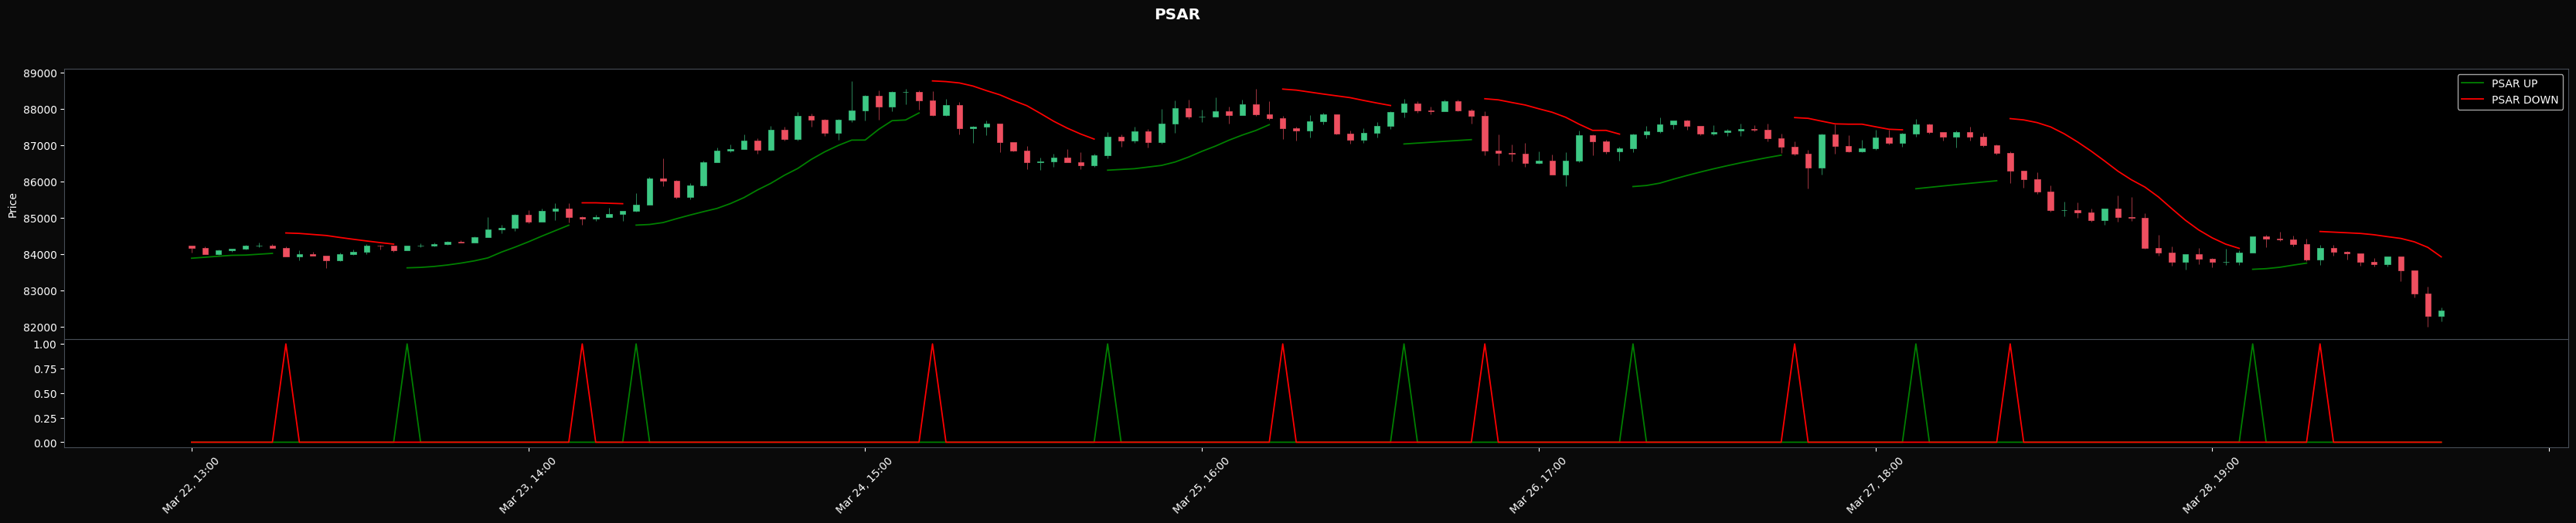

psar -> False


In [14]:
psar = PSARIndicator(btc_data["High"], btc_data["Low"], btc_data["Close"], step=0.02, max_step=0.2)

mpf.plot(btc_data.tail(NUM_OF_CANDLES), type="candle", title="PSAR", style=STYLE, figsize=FIGSIZE, addplot=[
    mpf.make_addplot(psar.psar_up().tail(NUM_OF_CANDLES), color="g", label="PSAR UP"),
    mpf.make_addplot(psar.psar_down().tail(NUM_OF_CANDLES), color="r", label="PSAR DOWN"),
    mpf.make_addplot(psar.psar_up_indicator().tail(NUM_OF_CANDLES), color="g", panel=1),
    mpf.make_addplot(psar.psar_down_indicator().tail(NUM_OF_CANDLES), color="r", panel=1)
])

print("psar ->", False if pd.isna(psar.psar_up().iloc[-2]) else True)

indicators["psar"] = False if pd.isna(psar.psar_up().iloc[-2]) else True

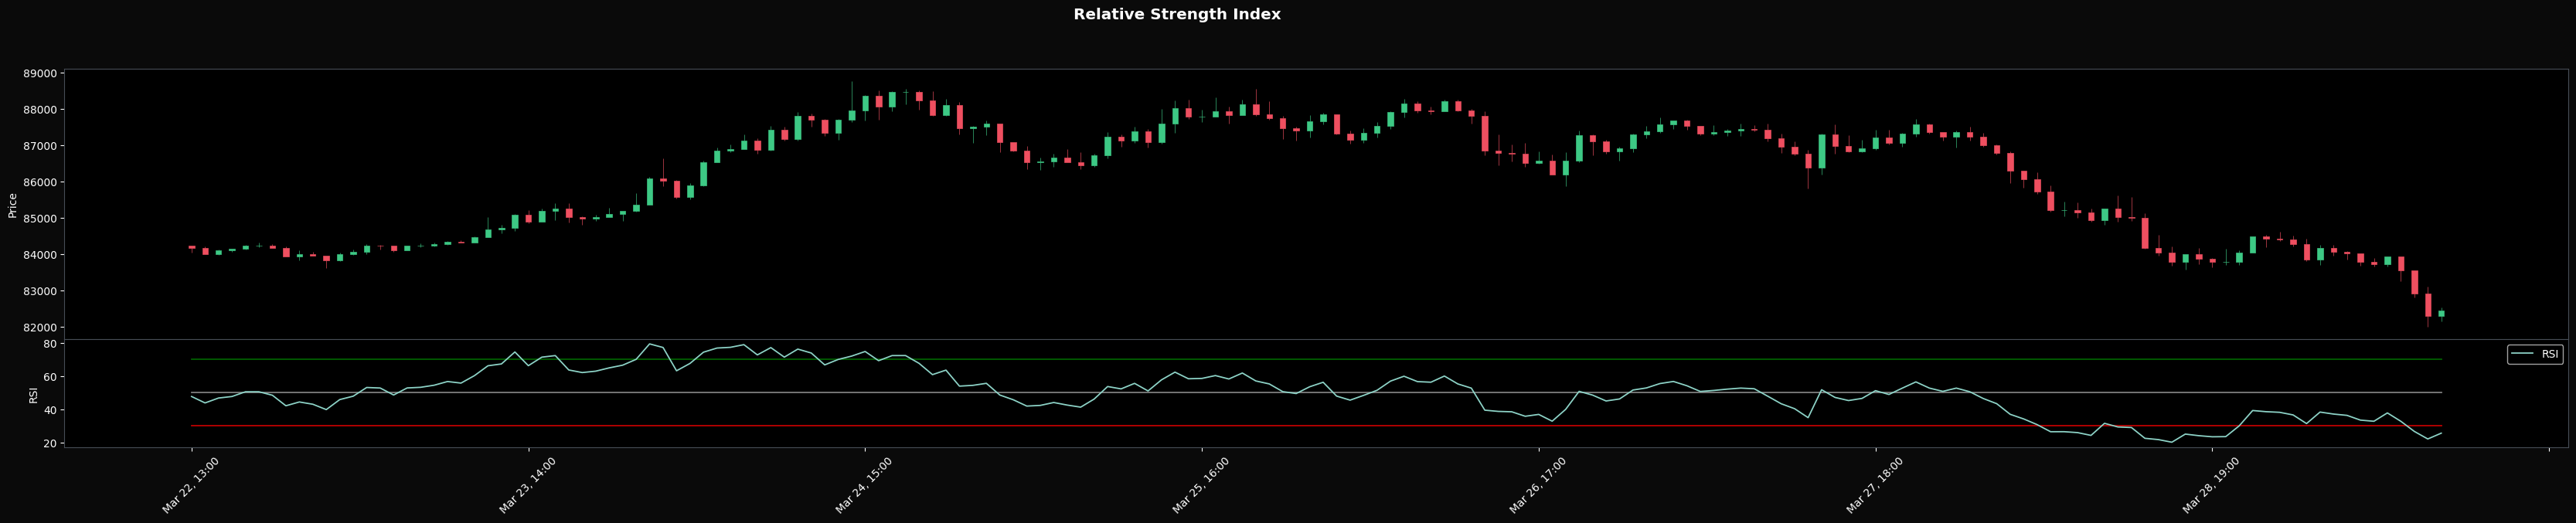

rsi -> False


In [15]:
rsi = RSIIndicator(btc_data["Close"], window=14).rsi()

mpf.plot(btc_data.tail(NUM_OF_CANDLES), type="candle", title="Relative Strength Index", style=STYLE, figsize=FIGSIZE, addplot=[
    mpf.make_addplot([70] * len(btc_data.tail(NUM_OF_CANDLES)), color="g", alpha=0.75, secondary_y=False, ylabel="RSI", panel=1),
    mpf.make_addplot([50] * len(btc_data.tail(NUM_OF_CANDLES)), color="w", alpha=0.50, secondary_y=False, ylabel="RSI", panel=1),
    mpf.make_addplot([30] * len(btc_data.tail(NUM_OF_CANDLES)), color="r", alpha=0.75, secondary_y=False, ylabel="RSI", panel=1),
    mpf.make_addplot(rsi.tail(NUM_OF_CANDLES), label="RSI", panel=1)
])

print("rsi ->", rsi.iloc[-1] > 50)

indicators["rsi"] = bool(rsi.iloc[-1] > 50)

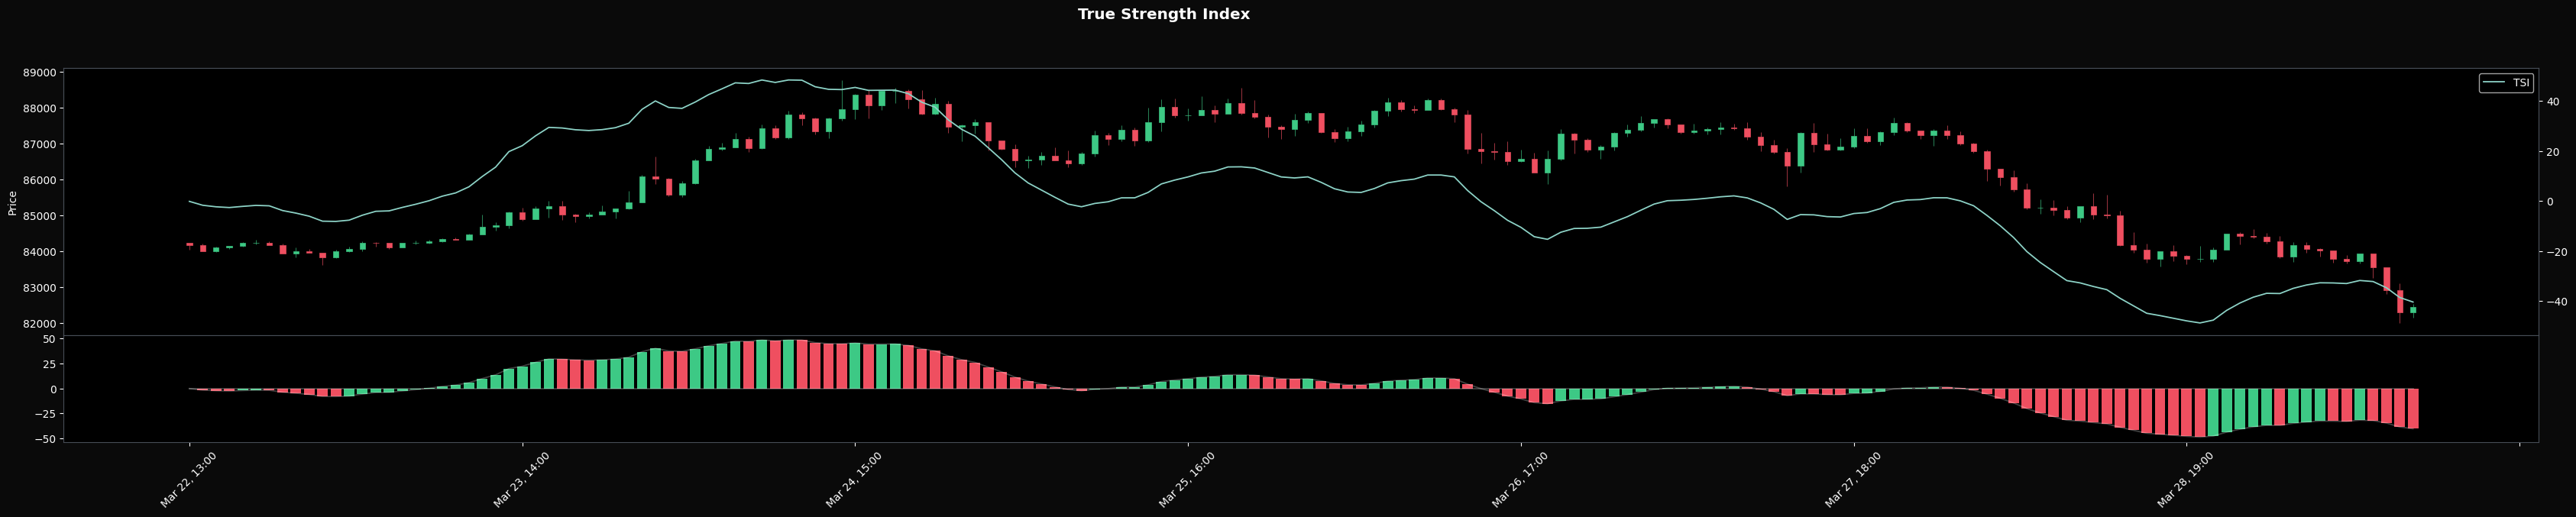

tsi -> False


In [16]:
tsi = TSIIndicator(btc_data["Close"], window_slow=25, window_fast=13).tsi()

mpf.plot(btc_data.tail(NUM_OF_CANDLES), type="candle", title="True Strength Index", style=STYLE, figsize=FIGSIZE, addplot=[
    mpf.make_addplot(tsi.tail(NUM_OF_CANDLES), label="TSI"), *_create_histogram(tsi.tail(NUM_OF_CANDLES), panel=1)
])

print("tsi ->", tsi.iloc[-1] > 0)

indicators["tsi"] = bool(tsi.iloc[-1] > 0)

In [17]:
indicators

{'fast_sma': False,
 'slow_sma': False,
 'sma_crossover': False,
 'fast_ema': False,
 'slow_ema': False,
 'ema_crossover': False,
 'macd': False,
 'psar': False,
 'rsi': False,
 'tsi': False}